# Ant Colony Optimization

The first thing we will do is write a simple script that simulates the foraging behaviour of ants, adapted from the following sources on Ant Colony Optimization (ACO)

1. [ACO_Wiki](https://en.wikipedia.org/wiki/Ant_colony_optimization_algorithms)
2. [Continious Orthogonal Ant Optimazation](https://link.springer.com/article/10.1007%2Fs11390-008-9111-5)

## Create a moving Agent

The first step in creating out ACO algorithm is to create a moving agent that changes direction with subtle randomness. To do this we implement the two classes below. The first class is the field the agents will move in, and the second is the actual agent class with some basic movement functionality that includes the ability to change direction after some time.


In [9]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.animation as animation

# Set up a seed
SEED = 1234567890
np.random.seed(SEED)

In [2]:
# Global Helper functions
def unit(x):
    '''Returns a unit vector for x'''
    return x/np.sqrt(np.dot(x,x))

# We will first create a class for a simple field for everything to live in
class Field:

    # Constructor
    def __init__(self,bounds:np.array=np.array([[0,1],[0,1]])):
        self.bounds = bounds

    # Generate a random position within the map
    def random_position(self):
        return np.array([ x*abs(self.bounds[i][1]-self.bounds[i][0]) + min(self.bounds[i]) for i,x in enumerate(np.random.rand(self.bounds.shape[0]))])

    # return a random unit vector with the dimensions of the borad
    def random_unit_vector(self):
        return unit(np.random.rand(self.bounds.shape[0])*2-np.array([1,1]))


# Create a class for an agent
class Agent:
    ID_cnt = 0          # Static variable to hold the IDs

    # Constructor
    def __init__(self,ID:int = -1, pos:np.array = np.array([None,None]), field:Field = Field()):
        
        # Assign a unique ID
        self.ID = Agent.ID_cnt if ID == -1 else ID
        Agent.ID_cnt += 1

        # Assign the field variable
        self.field = field

        # Determine if to create a random position
        self.pos = self.field.random_position() if (pos == np.array([None,None])).all() else pos

        # It's velocity will also be a vector initialized at 0
        self.vel = np.zeros(self.pos.shape)
        self.desired_vel = np.zeros(self.pos.shape)

    # This will update the position based on the velocity
    def move(self,dt):
        self.pos = self.vel * dt + self.pos

    # This will update the velocity using certain randomness
    def update_velocity(self,dt,acc_magnitude=1,desired_speed=1,randomness=0.5):
        # First we update the desired velocity
        self.desired_vel = unit(self.field.random_unit_vector()*randomness + self.desired_vel) * desired_speed

        # After having a new desired speed we calculate the acceleration required to reach that speed
        acc = unit(self.desired_vel - self.vel) * acc_magnitude

        # Finally, update the velocity based on the past accelleration
        self.vel = self.vel + acc*dt


In [3]:
# Now we test Let's create a function that would put an agent in a field and run it with our parameters

# Agent motion properties
acc_magnitude   = 2
desired_speed   = 1
randomness      = 10
dt              = 0.01
max_time        = 10

def run_one_agent(field:Field,dt=dt,max_time=max_time,acc_magnitude=acc_magnitude,desired_speed=desired_speed,randomness=randomness):
    # Create an agent
    agent = Agent(pos=np.array([0.5,0.5]),field=field)

    # Simulate the agent's motion for some arbitrary time
    time = np.arange(0,max_time,dt)


    

    # An array to solve the position
    pos = [agent.pos]

    # Simulate
    for t in time:
        agent.update_velocity(dt,acc_magnitude,desired_speed,randomness)
        agent.move(dt)

        pos.append(agent.pos)

    pos = np.array(pos)

    return pos

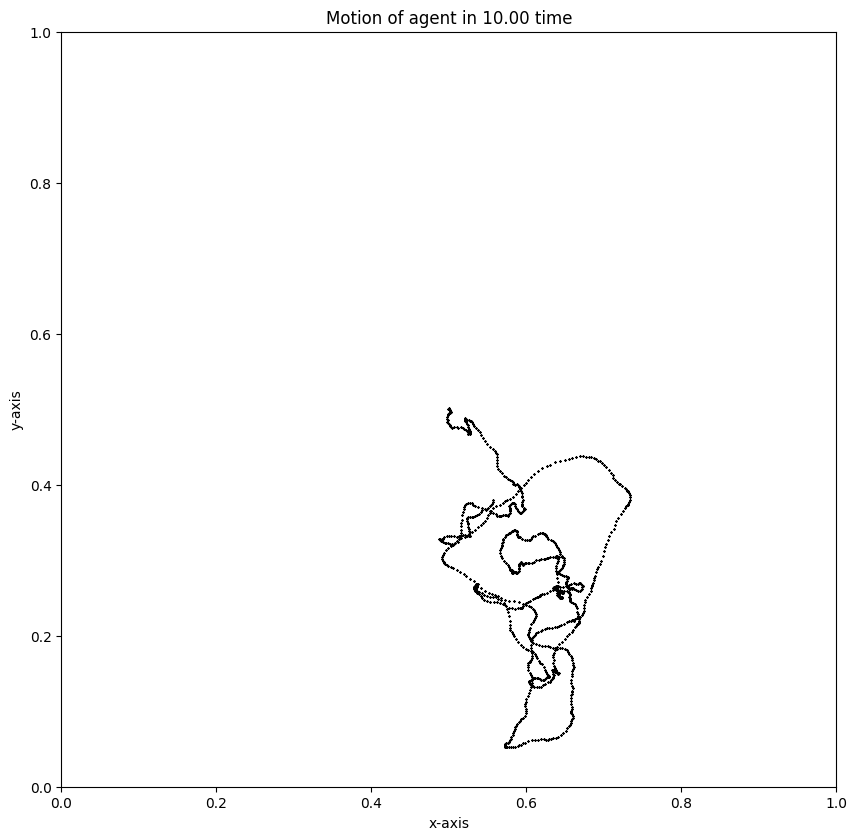

In [28]:
# Now plot the position array
field = Field()

# Agent motion properties
acc_magnitude   = 10
desired_speed   = 1
randomness      = 10
dt              = 0.01
max_time        = 10

pos = run_one_agent(field,dt,max_time,acc_magnitude,desired_speed,randomness)

# Create the figure and setup athe axis
fig = plt.figure(figsize=(10,10),dpi=100)
ax  = fig.add_subplot(111)
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_title('Motion of agent in %.2f time'%max_time)
ax.set_xlim(*field.bounds[0])
ax.set_ylim(*field.bounds[1])

# plot the position
plt.scatter(*(pos.T),s=1,marker='x',c='k');

In [13]:
# A counter for our animations
anim_cnt = 0

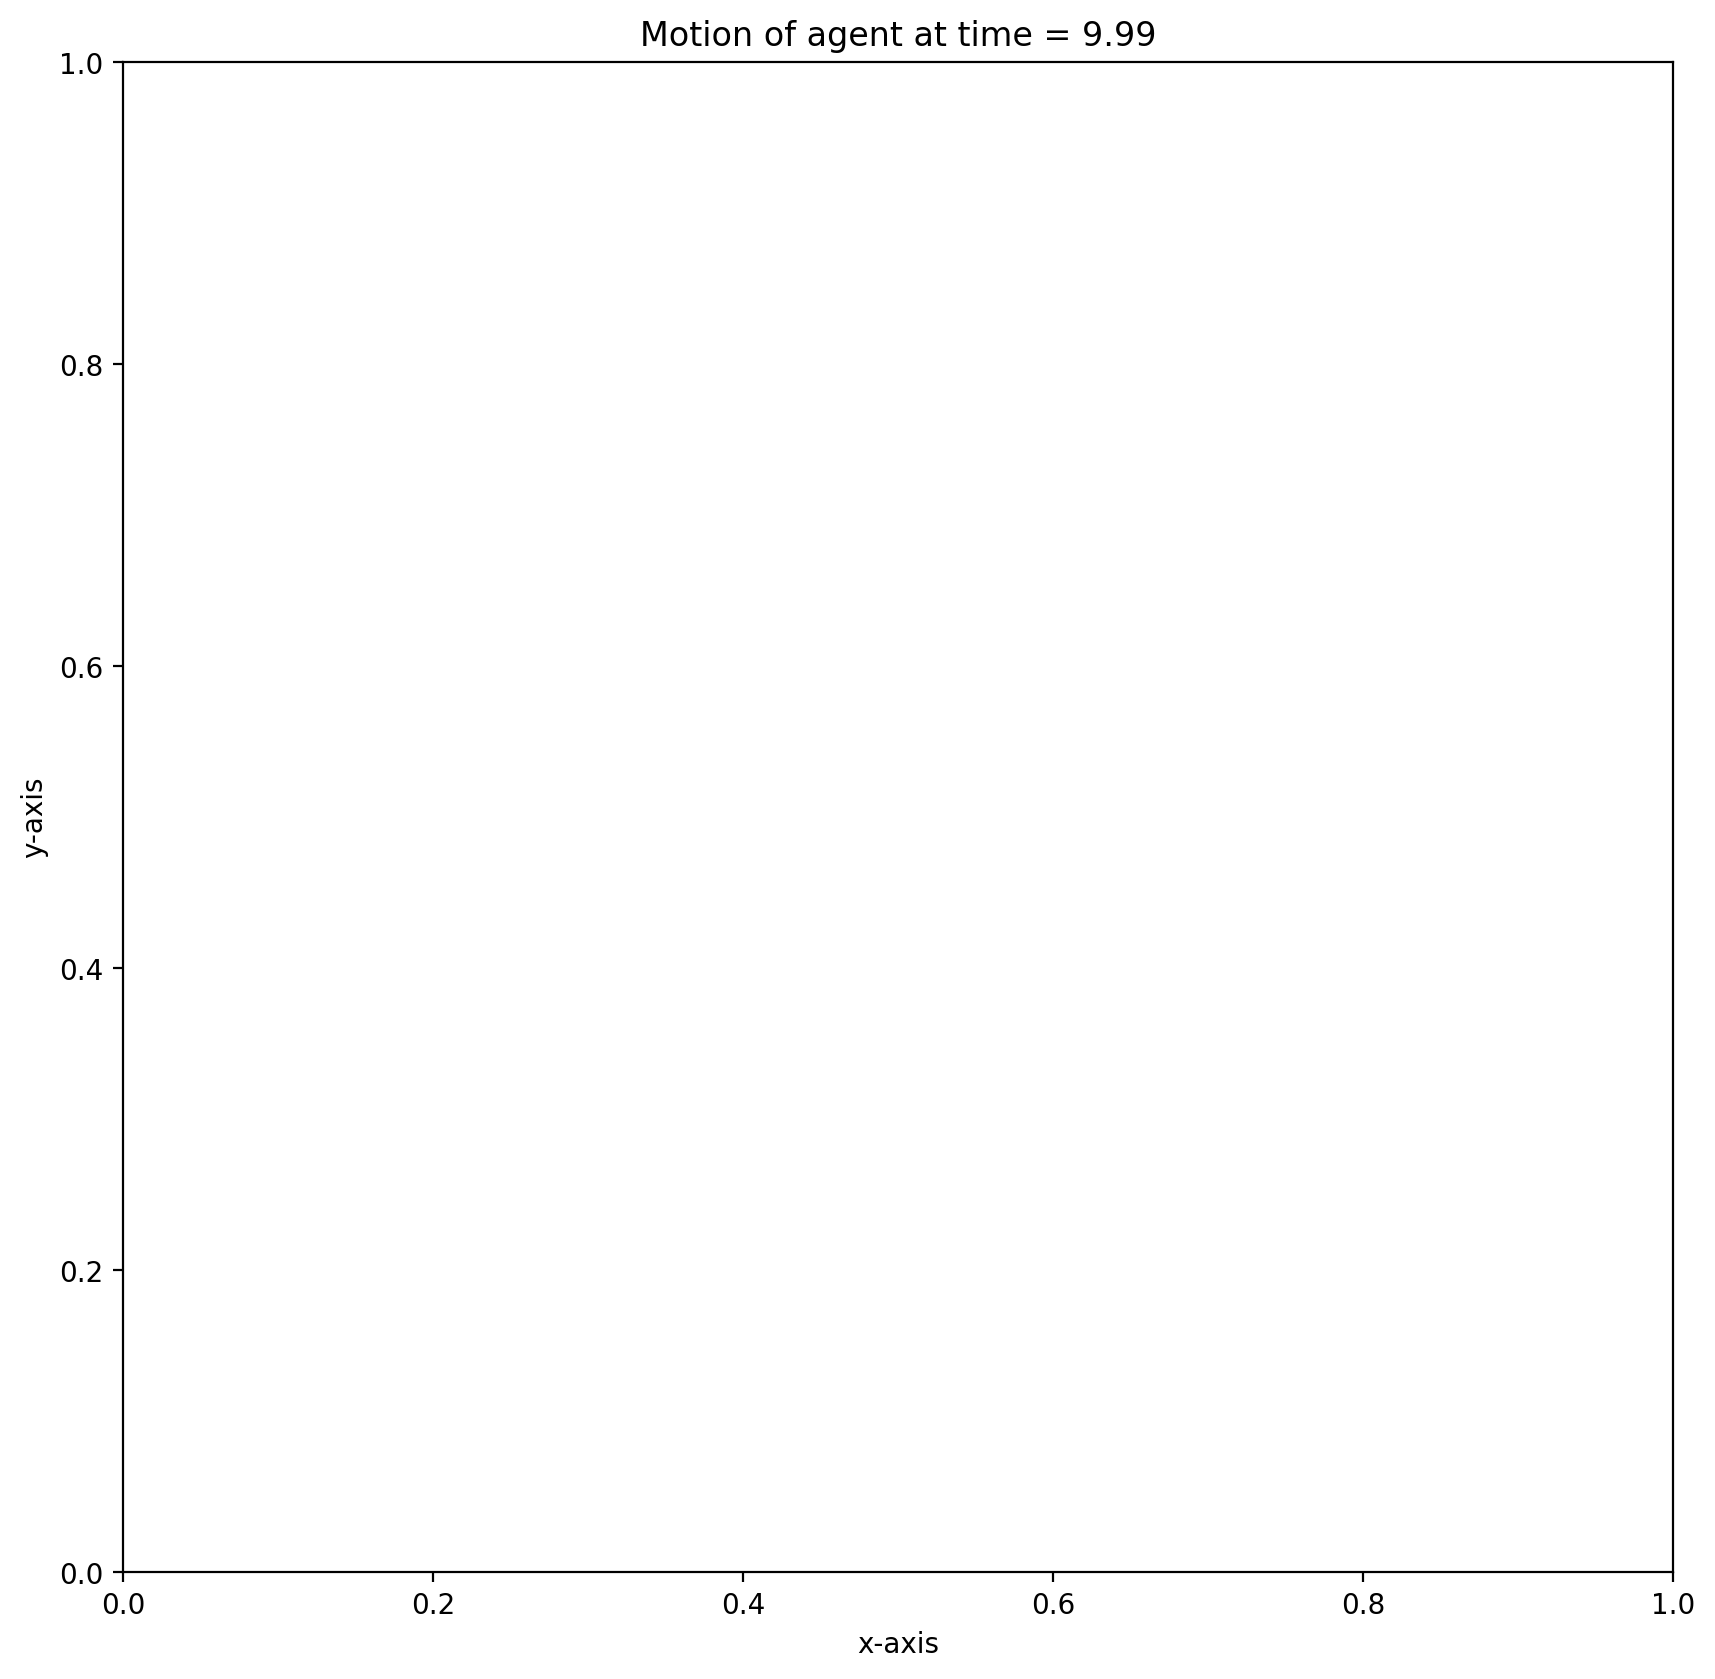

In [29]:
# We can create a quick animation just to make sure

# First we get some data
field = Field()

# Agent motion properties
acc_magnitude   = 10
desired_speed   = 1
randomness      = 10
dt              = 0.01
max_time        = 10

time = np.arange(0,max_time,dt)
pos = run_one_agent(field,dt,max_time,acc_magnitude,desired_speed,randomness)

# Now we will define a figure
# Create the figure and setup athe axis
fig = plt.figure(figsize=(10,10),dpi=200)
ax  = fig.add_subplot(111)
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_title('Motion of agent at time = %.2f'%time[0])
ax.set_xlim(*field.bounds[0])
ax.set_ylim(*field.bounds[1])

# Now the plot element
dot, = plt.plot([],[],'ko',ms=3)

# Define our update function
def update(i):
    # Get some variables from the global scope
    global ax,dot,pos,time

    # Set our new data
    dot.set_data([pos[i][0]],[pos[i][1]])
    ax.set_title('Motion of agent at time = %.2f'%time[i])

    return dot,

# Animate!
anim = animation.FuncAnimation(fig,update,frames=len(time),blit=True)
writer = animation.writers['ffmpeg'](fps=60)
anim.save('Animations/1_Particle_Test-%d.mp4'%anim_cnt,writer=writer,dpi=200)
anim_cnt+=1

## Adding a sense of direction

Now that we have implemented a way for the ants to move randomply around a terrain we should add a sense of directionality to them 